In [1]:
!apt-get update -qq
!apt install msttcorefonts -y -qq
!rm ~/.cache/matplotlib -rf

The following additional packages will be installed:
  cabextract distro-info libmspack0 python3-debconf python3-debian
  python3-distro-info python3-distupgrade python3-update-manager python3-yaml
  ubuntu-advantage-tools ubuntu-pro-client ubuntu-pro-client-l10n
  ubuntu-release-upgrader-core update-manager-core update-notifier-common
Suggested packages:
  shunit2 python3-launchpadlib
The following NEW packages will be installed:
  cabextract distro-info libmspack0 python3-debconf python3-debian
  python3-distro-info python3-distupgrade python3-update-manager python3-yaml
  ttf-mscorefonts-installer ubuntu-advantage-tools ubuntu-pro-client
  ubuntu-pro-client-l10n ubuntu-release-upgrader-core update-manager-core
  update-notifier-common
0 upgraded, 16 newly installed, 0 to remove and 71 not upgraded.
Need to get 892 kB of archives.
After this operation, 5555 kB of additional disk space will be used.
Preconfiguring packages ...

78Selecting previously unselected package libmspack0:am

In [2]:
import pandas as pd
from torch.utils.data import Dataset
import torch
import os
import random
import numpy as np
from torch import nn
from typing import Dict, Optional, Tuple, List
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import Dataset, random_split
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import precision_score, f1_score, recall_score, classification_report


import time
import math
import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
import networkx as nx

%matplotlib inline
from IPython.display import clear_output

In [3]:
SEED = 42

torch.manual_seed(SEED)
torch.random.manual_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.cuda.random.manual_seed(SEED)
torch.cuda.random.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True

In [4]:
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["axes.titlesize"] = 12
plt.rcParams["axes.labelsize"] = 11
plt.rcParams["xtick.labelsize"] = 11
plt.rcParams["ytick.labelsize"] = 11
plt.rcParams["legend.fontsize"] = 11
plt.rcParams["axes.linewidth"] = 1
plt.rcParams["figure.dpi"] = 90
plt.rcParams["grid.linewidth"] = 1
plt.rcParams.keys()

KeysView(RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': ['-layers', 'OptimizePlus'],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': 'line',
          'axes.edgecolor': 'black',
          'axes.facecolor': 'white',
          'axes.formatter.limits': [-5, 6],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
          'axes.formatter.useoffset': True,
          'axes.grid': False,
          'axes.grid.axis': 'b

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [6]:
!git clone https://github.com/uhh-lt/TextGraphs17-shared-task.git

Cloning into 'TextGraphs17-shared-task'...
remote: Enumerating objects: 506, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 506 (delta 9), reused 20 (delta 4), pack-reused 480
Receiving objects: 100% (506/506), 37.13 MiB | 19.51 MiB/s, done.
Resolving deltas: 100% (60/60), done.


In [7]:
!ls TextGraphs17-shared-task

README.md  data        question_graph_examples	submission_example
baselines  evaluation  reformat_data		visualization


In [8]:
train_dev_path = "TextGraphs17-shared-task/data/tsv/train.tsv"

data_df = pd.read_csv(train_dev_path, sep='\t')

pd.set_option('display.max_colwidth', None)

In [9]:
all_questions = list(data_df["question"].unique())
num_questions = len(all_questions)
random.shuffle(all_questions)

In [10]:
train_dev_ratio = 0.8
train_ratio = 0.9
num_train_dev_questions = int(num_questions * train_dev_ratio)
train_dev_questions = all_questions[:num_train_dev_questions]
test_questions = set(all_questions[num_train_dev_questions:])
num_train_questions = int(len(train_dev_questions) * train_ratio)
train_questions = set(train_dev_questions[:num_train_questions])
dev_questions = set(train_dev_questions[num_train_questions:])

print(f"Questions: train - {len(train_questions)}, dev - {len(dev_questions)}, test - {len(dev_questions)}")

Questions: train - 2545, dev - 283, test - 283


In [11]:
train_df = data_df[data_df["question"].isin(train_questions)]
dev_df = data_df[data_df["question"].isin(dev_questions)]
test_df = data_df[data_df["question"].isin(test_questions)]

print(f"Train: {train_df.shape}")
print(f"Dev: {dev_df.shape}")
print(f"Test: {test_df.shape}")

Train: (27122, 10)
Dev: (3047, 10)
Test: (7503, 10)


In [12]:
train_df["label"] = train_df["correct"].astype(np.float32)
dev_df["label"] = dev_df["correct"].astype(np.float32)
test_df["label"] = test_df["correct"].astype(np.float32)
train_df["label"].head(5)

/tmp/ipykernel_34/3117296500.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["label"] = train_df["correct"].astype(np.float32)
/tmp/ipykernel_34/3117296500.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dev_df["label"] = dev_df["correct"].astype(np.float32)
/tmp/ipykernel_34/3117296500.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas

0    0.0
1    0.0
2    0.0
3    1.0
4    0.0
Name: label, dtype: float32

In [13]:
train_df["graph"] = train_df["graph"].apply(eval)
dev_df["graph"] = dev_df["graph"].apply(eval)
test_df["graph"] = test_df["graph"].apply(eval)

/tmp/ipykernel_34/1764180835.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["graph"] = train_df["graph"].apply(eval)
/tmp/ipykernel_34/1764180835.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dev_df["graph"] = dev_df["graph"].apply(eval)
/tmp/ipykernel_34/1764180835.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas

In [14]:
data_df.head(1)

,sample_id,question,questionEntity,answerEntity,groundTruthAnswerEntity,answerEntityId,questionEntityId,groundTruthAnswerEntityId,correct,graph
0,0,Whst is the name of the head of state and highest ranking political and religious authority in Iran?,Iran,Ruhollah Khomeini's return to Iran,Office of the Supreme Leader of Iran,Q7293530,Q794,Q16045000,False,"{'nodes': [{'type': 'QUESTIONS_ENTITY', 'name_': 'Q794', 'id': 0, 'label': 'Iran'}, {'type': 'INTERNAL', 'name_': 'Q207991', 'id': 1, 'label': 'Pahlavi dynasty'}, {'type': 'ANSWER_CANDIDATE_ENTITY', 'name_': 'Q7293530', 'id': 2, 'label': ""Ruhollah Khomeini's return to Iran""}], 'links': [{'name_': 'P17', 'source': 0, 'target': 0, 'label': 'country'}, {'name_': 'P1365', 'source': 0, 'target': 1, 'label': 'replaces'}, {'name_': 'P1366', 'source': 1, 'target': 0, 'label': 'replaced by'}, {'name_': 'P17', 'source': 2, 'target': 1, 'label': 'country'}]}"


In [15]:
class QuestionAnswerDataset(Dataset):
    
    def __init__(self, df, tokenizer, max_length, context_key="answerEntity",
                 tokenizer_truncation="only_first", graph_length="length", graph_density="density",
                 degree_centrality="Degree Centrality", eigenvector_centrality="Eigenvector Centrality",
                closeness_centrality="Closeness Centrality", page_rank="Page Rank"):
        
        super(QuestionAnswerDataset).__init__()

        self.questions = df.question.values
        self.contexts = df[context_key].values
        
        self.graph_length = df[graph_length].values
        self.graph_density = df[graph_density].values
        
        self.degree_centrality = df[degree_centrality].values
        self.eigenvector_centrality = df[eigenvector_centrality].values
        self.closeness_centrality = df[closeness_centrality].values
        self.page_rank = df[page_rank].values
        
        self.labels = torch.tensor(df.label.values, dtype=torch.float32)
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.tokenized_input = [tokenizer.encode_plus(x, y,
                              max_length=self.max_length,
                              padding="max_length",
                              truncation=tokenizer_truncation,
                              return_tensors="pt", ) \
                          for x, y in zip(self.questions,
                                          self.contexts)]
        
        assert len(self.questions) == len(self.contexts) == len(self.labels)

    def __len__(self):
        return len(self.questions)

    def __getitem__(self, idx):
        return {
                "input_ids": self.tokenized_input[idx]["input_ids"][0],
                "attention_mask" : self.tokenized_input[idx]["attention_mask"][0],
                "labels": self.labels[idx],
                "graph_length": self.graph_length[idx],
                "graph_density": self.graph_density[idx],
                "degree_centrality": self.degree_centrality[idx],
                "eigenvector_centrality": self.eigenvector_centrality[idx],
                "closeness_centrality": self.closeness_centrality[idx],
                "page_rank": self.page_rank[idx],
                }

In [16]:
# ["Degree Centrality", "Eigenvector Centrality", "Closeness Centrality", "Page Rank"]

# Graph Linearization

In [17]:
model_name="sentence-transformers/all-MiniLM-L6-v2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
SEP_TOKEN = tokenizer.sep_token

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [18]:
# {'directed': True, 'multigraph': False, 'graph': {},
# 'nodes': [{'type': 'QUESTIONS_ENTITY', 'name_': 'Q49', 'id': 0, 'label': 'North America'},
# {'type': 'ANSWER_CANDIDATE_ENTITY', 'name_': 'Q194057', 'id': 1, 'label': 'Mount Rainier'}],
# 'links': [{'name_': 'P30', 'source': 1, 'target': 0, 'label': 'continent'}]}
def linearize_graph(graph_dict):
    graph_dict = graph_dict["graph"]

    nodes = sorted((node_dict for node_dict in graph_dict["nodes"]), key=lambda d:d["id"])

    len_nodes = len(nodes)
    len_links = len(graph_dict["links"])
    if len_nodes > 1:
        kn_density =  len_links / (len_nodes * (len_nodes - 1))
    else:
        kn_density =  len_links / (len_nodes * (len_nodes))


    for n_id, node_dict in enumerate(nodes):
        assert n_id == node_dict["id"]
    src_node_id2links = {}

    for link_dict in graph_dict["links"]:

        link_src =  link_dict["source"]

        if src_node_id2links.get(link_src) is None:
            src_node_id2links[link_src] = []
        src_node_id2links[link_src].append(link_dict)

    graph_s = ""

    for n_id, node_dict in enumerate(nodes):
        links = src_node_id2links.get(n_id, list())
        start_label = node_dict["label"]
        if node_dict["type"] == "ANSWER_CANDIDATE_ENTITY":
            start_label = f"{SEP_TOKEN} {start_label} {SEP_TOKEN}"
        for link_dict in links:
            target_label = nodes[link_dict["target"]]["label"]
            if nodes[link_dict["target"]]["type"] == "ANSWER_CANDIDATE_ENTITY":
                target_label = f"{SEP_TOKEN} {target_label} {SEP_TOKEN}"
            link_s = f" {start_label}, {link_dict['label']}, {target_label} "

            graph_s += link_s
        # graph_s += node_dict["label"]
        # if n_id != len(nodes) - 1:
        #     link_label = link["label"]
        #     graph_s += link_label
    #print('--------')
    return graph_s, len_nodes, kn_density

In [19]:
train_df.head(1)

,sample_id,question,questionEntity,answerEntity,groundTruthAnswerEntity,answerEntityId,questionEntityId,groundTruthAnswerEntityId,correct,graph,label
0,0,Whst is the name of the head of state and highest ranking political and religious authority in Iran?,Iran,Ruhollah Khomeini's return to Iran,Office of the Supreme Leader of Iran,Q7293530,Q794,Q16045000,False,"{'nodes': [{'type': 'QUESTIONS_ENTITY', 'name_': 'Q794', 'id': 0, 'label': 'Iran'}, {'type': 'INTERNAL', 'name_': 'Q207991', 'id': 1, 'label': 'Pahlavi dynasty'}, {'type': 'ANSWER_CANDIDATE_ENTITY', 'name_': 'Q7293530', 'id': 2, 'label': 'Ruhollah Khomeini's return to Iran'}], 'links': [{'name_': 'P17', 'source': 0, 'target': 0, 'label': 'country'}, {'name_': 'P1365', 'source': 0, 'target': 1, 'label': 'replaces'}, {'name_': 'P1366', 'source': 1, 'target': 0, 'label': 'replaced by'}, {'name_': 'P17', 'source': 2, 'target': 1, 'label': 'country'}]}",0.0


In [20]:
train_df["graph"][0]

{'nodes': [{'type': 'QUESTIONS_ENTITY',
   'name_': 'Q794',
   'id': 0,
   'label': 'Iran'},
  {'type': 'INTERNAL',
   'name_': 'Q207991',
   'id': 1,
   'label': 'Pahlavi dynasty'},
  {'type': 'ANSWER_CANDIDATE_ENTITY',
   'name_': 'Q7293530',
   'id': 2,
   'label': "Ruhollah Khomeini's return to Iran"}],
 'links': [{'name_': 'P17', 'source': 0, 'target': 0, 'label': 'country'},
  {'name_': 'P1365', 'source': 0, 'target': 1, 'label': 'replaces'},
  {'name_': 'P1366', 'source': 1, 'target': 0, 'label': 'replaced by'},
  {'name_': 'P17', 'source': 2, 'target': 1, 'label': 'country'}]}

In [21]:
#train_df["linearized_graph"] = train_df["graph"].apply(linearize_graph)
#dev_df["linearized_graph"] = dev_df["graph"].apply(linearize_graph)
#test_df["linearized_graph"] = test_df["graph"].apply(linearize_graph)

train_df["linearized_graph"], train_df["length"], train_df["density"] = zip(*train_df.apply(linearize_graph, axis=1))
dev_df["linearized_graph"], dev_df["length"], dev_df["density"] = zip(*dev_df.apply(linearize_graph, axis=1))
test_df["linearized_graph"], test_df["length"], test_df["density"] = zip(*test_df.apply(linearize_graph, axis=1))

/tmp/ipykernel_34/3641409960.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["linearized_graph"], train_df["length"], train_df["density"] = zip(*train_df.apply(linearize_graph, axis=1))
/tmp/ipykernel_34/3641409960.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["linearized_graph"], train_df["length"], train_df["density"] = zip(*train_df.apply(linearize_graph, axis=1))
/tmp/ipykernel_34/3641409960.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

In [22]:
train_df.head(2)

,sample_id,question,questionEntity,answerEntity,groundTruthAnswerEntity,answerEntityId,questionEntityId,groundTruthAnswerEntityId,correct,graph,label,linearized_graph,length,density
0,0,Whst is the name of the head of state and highest ranking political and religious authority in Iran?,Iran,Ruhollah Khomeini's return to Iran,Office of the Supreme Leader of Iran,Q7293530,Q794,Q16045000,False,"{'nodes': [{'type': 'QUESTIONS_ENTITY', 'name_': 'Q794', 'id': 0, 'label': 'Iran'}, {'type': 'INTERNAL', 'name_': 'Q207991', 'id': 1, 'label': 'Pahlavi dynasty'}, {'type': 'ANSWER_CANDIDATE_ENTITY', 'name_': 'Q7293530', 'id': 2, 'label': 'Ruhollah Khomeini's return to Iran'}], 'links': [{'name_': 'P17', 'source': 0, 'target': 0, 'label': 'country'}, {'name_': 'P1365', 'source': 0, 'target': 1, 'label': 'replaces'}, {'name_': 'P1366', 'source': 1, 'target': 0, 'label': 'replaced by'}, {'name_': 'P17', 'source': 2, 'target': 1, 'label': 'country'}]}",0.0,"Iran, country, Iran Iran, replaces, Pahlavi dynasty Pahlavi dynasty, replaced by, Iran [SEP] Ruhollah Khomeini's return to Iran [SEP], country, Pahlavi dynasty",3,0.666667
1,1,Whst is the name of the head of state and highest ranking political and religious authority in Iran?,Iran,Ruhollah Khomeini's letter to Mikhail Gorbachev,Office of the Supreme Leader of Iran,Q5952984,Q794,Q16045000,False,"{'nodes': [{'type': 'INTERNAL', 'name_': 'Q4173137', 'id': 0, 'label': 'Jewish Encyclopedia of Brockhaus and Efron'}, {'type': 'QUESTIONS_ENTITY', 'name_': 'Q794', 'id': 1, 'label': 'Iran'}, {'type': 'INTERNAL', 'name_': 'Q47461344', 'id': 2, 'label': 'written work'}, {'type': 'INTERNAL', 'name_': 'Q133492', 'id': 3, 'label': 'letter'}, {'type': 'INTERNAL', 'name_': 'Q1030940', 'id': 4, 'label': 'The Book of Healing'}, {'type': 'ANSWER_CANDIDATE_ENTITY', 'name_': 'Q5952984', 'id': 5, 'label': 'Ruhollah Khomeini's letter to Mikhail Gorbachev'}], 'links': [{'name_': 'P1343', 'source': 1, 'target': 0, 'label': 'described by source'}, {'name_': 'P17', 'source': 1, 'target': 1, 'label': 'country'}, {'name_': 'P1343', 'source': 3, 'target': 0, 'label': 'described by source'}, {'name_': 'P279', 'source': 3, 'target': 2, 'label': 'subclass of'}, {'name_': 'P495', 'source': 4, 'target': 1, 'label': 'country of origin'}, {'name_': 'P31', 'source': 4, 'target': 2, 'label': 'instance of'}, {'name_': 'P31', 'source': 5, 'target': 2, 'label': 'instance of'}, {'name_': 'P31', 'source': 5, 'target': 3, 'label': 'instance of'}]}",0.0,"Iran, described by source, Jewish Encyclopedia of Brockhaus and Efron Iran, country, Iran letter, described by source, Jewish Encyclopedia of Brockhaus and Efron letter, subclass of, written work The Book of Healing, country of origin, Iran The Book of Healing, instance of, written work [SEP] Ruhollah Khomeini's letter to Mikhail Gorbachev [SEP], instance of, written work [SEP] Ruhollah Khomeini's letter to Mikhail Gorbachev [SEP], instance of, letter",6,0.266667


# Data exploration

In [23]:
train_exploration_df = pd.DataFrame()
train_exploration_df["correct"], train_exploration_df["length"], train_exploration_df["density"] = train_df["correct"], train_df["length"], train_df["density"]
train_exploration_df.head(3)

,correct,length,density
0,False,3,0.666667
1,False,6,0.266667
2,False,2,1.500000


array([[<Axes: title={'center': 'length'}>,
        <Axes: title={'center': 'density'}>]], dtype=object)

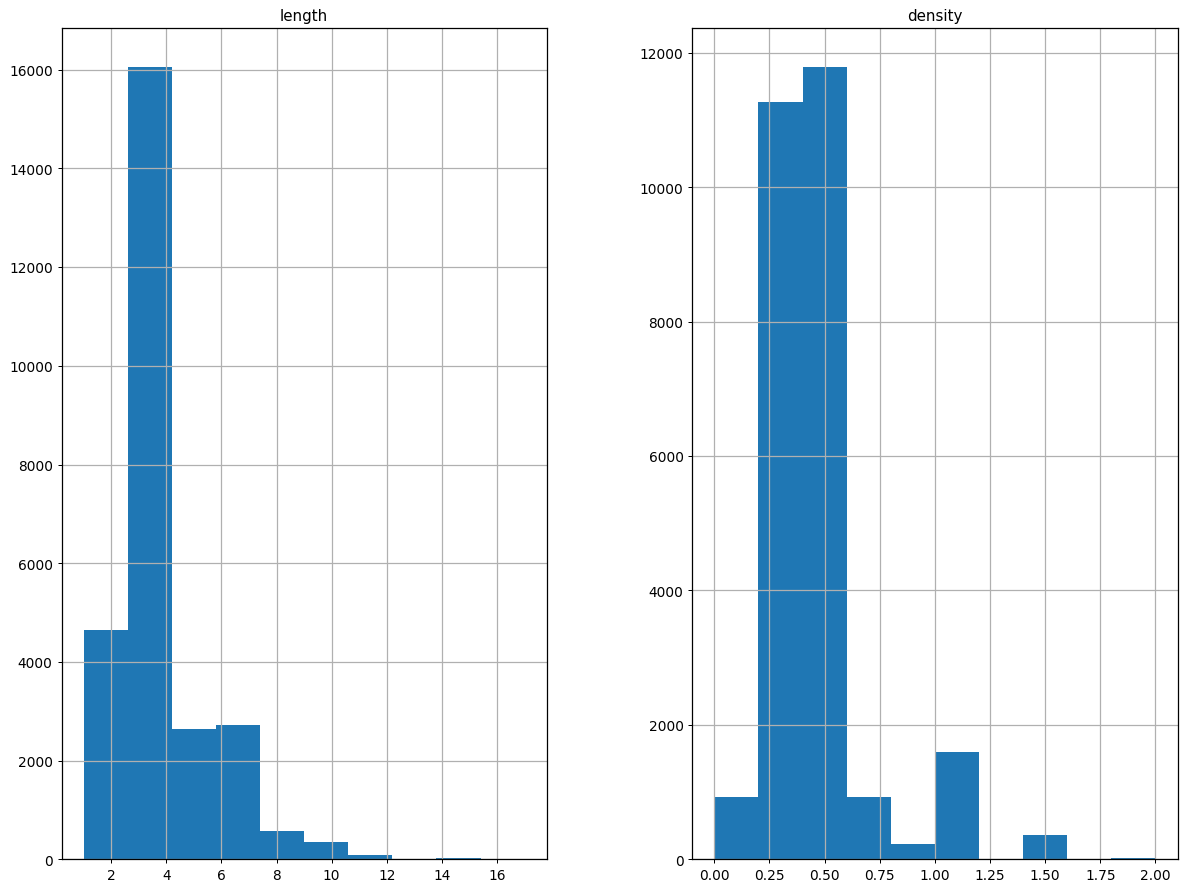

In [24]:
train_exploration_df.hist()

In [25]:
train_exploration_df.groupby("correct").mean()

,length,density
correct,,
False,3.925680,0.440844
True,3.086342,0.545361


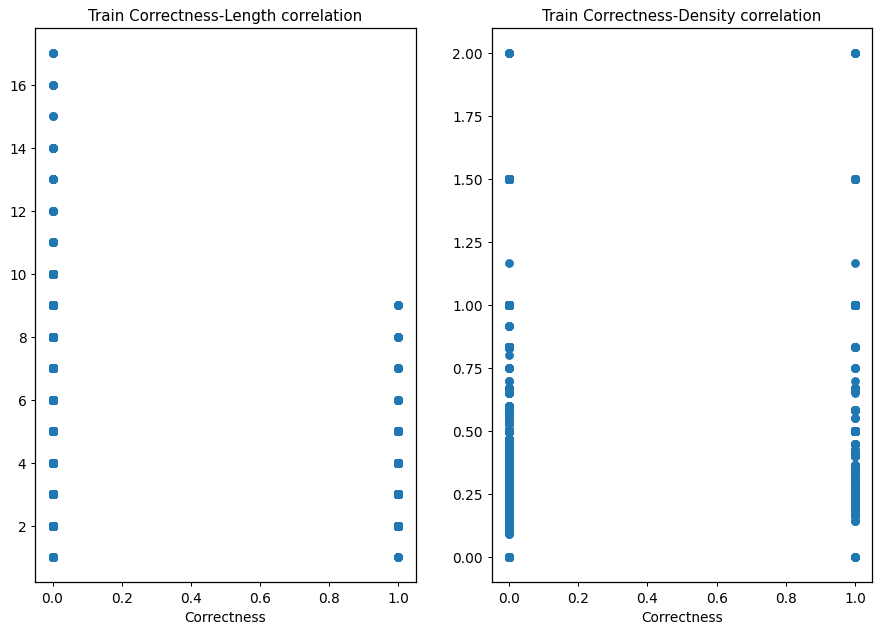

In [26]:
csfont = {'fontname':'Times New Roman'}

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))
#.astype('int32')
ax[0].scatter(train_exploration_df["correct"], train_exploration_df["length"])
ax[0].set_xlabel('Correctness')
ax[0].set_title('Train Correctness-Length correlation', **csfont)

ax[1].scatter(train_exploration_df["correct"], train_exploration_df["density"])
ax[1].set_xlabel('Correctness')
ax[1].set_title('Train Correctness-Density correlation', **csfont)

plt.show()

In [27]:
test_exploration_df = pd.DataFrame()
test_exploration_df["correct"], test_exploration_df["length"], test_exploration_df["density"] = test_df["correct"], test_df["length"], test_df["density"]
test_exploration_df.head(3)

,correct,length,density
11,False,2,0.5
12,False,3,0.5
13,False,2,0.5


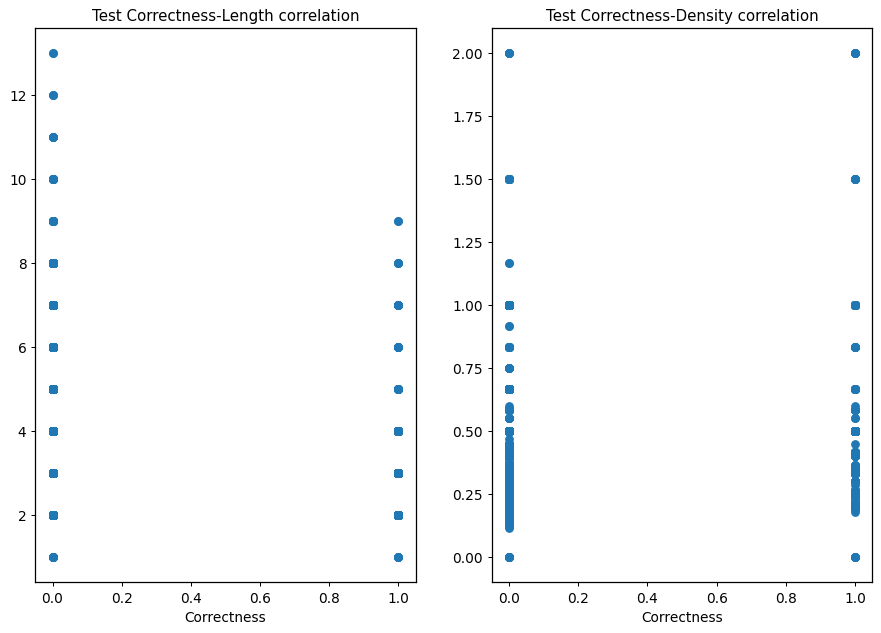

In [28]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))
#.astype('int32')
ax[0].scatter(test_exploration_df["correct"], test_exploration_df["length"])
ax[0].set_xlabel('Correctness')
ax[0].set_title('Test Correctness-Length correlation')

ax[1].scatter(test_exploration_df["correct"], test_exploration_df["density"])
ax[1].set_xlabel('Correctness')
ax[1].set_title('Test Correctness-Density correlation')

plt.show()

In [29]:
len(train_df)

27122

# Model Preparation

In [30]:
def train(model, iterator, optimizer, criterion, device,
          train_history=None, valid_history=None,):
    model.train()

    epoch_loss = 0
    history = []
    for i, batch in enumerate(tqdm(iterator)):

        optimizer.zero_grad()

        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        graph_length = batch["graph_length"].to(device)
        graph_density = batch["graph_density"].to(device)
        
        degree_centrality = batch["degree_centrality"].to(device) 
        eigenvector_centrality = batch["eigenvector_centrality"].to(device) 
        closeness_centrality = batch["closeness_centrality"].to(device) 
        page_rank = batch["page_rank"].to(device)

        output = model(inputs=input_ids, attention_mask=attention_mask, graph_length=graph_length, graph_density=graph_density,
                                degree_centrality=degree_centrality, eigenvector_centrality=eigenvector_centrality, 
                                closeness_centrality=closeness_centrality, page_rank=page_rank).squeeze(1)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()


        epoch_loss += loss.item()

        history.append(loss.cpu().data.numpy())

    return epoch_loss / (i + 1)

def evaluate(model, iterator, criterion, device):
    model.eval()

    epoch_loss = 0

    true_labels = []
    pred_labels = []

    with torch.no_grad():

        for i, batch in enumerate(iterator):

            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"]

            graph_length = batch["graph_length"].to(device)
            graph_density = batch["graph_density"].to(device)
            
            degree_centrality = batch["degree_centrality"].to(device) 
            eigenvector_centrality = batch["eigenvector_centrality"].to(device) 
            closeness_centrality = batch["closeness_centrality"].to(device) 
            page_rank = batch["page_rank"].to(device)

            true_labels.extend(labels.cpu().numpy())
            labels = labels.to(device)


            output = model(inputs=input_ids, attention_mask=attention_mask, graph_length=graph_length, graph_density=graph_density,
                                degree_centrality=degree_centrality, eigenvector_centrality=eigenvector_centrality, 
                                closeness_centrality=closeness_centrality, page_rank=page_rank).squeeze(1)
            
            pred_probas = output.cpu().numpy()
            batch_pred_labels = (pred_probas >= 0.5) * 1

            loss = criterion(output, labels)

            pred_labels.extend(batch_pred_labels)
            epoch_loss += loss.item()

    valid_f1_score = f1_score(true_labels, pred_labels)
    return epoch_loss / (i + 1), valid_f1_score

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [31]:
def train_evaluate(bert_classifier, train_loader, dev_loader, optimizer, scheduler, criterion, n_epochs, checkpoint_fname, device):
    train_history = []
    valid_history = []
    valid_history_f1 = []

    best_valid_loss = float('inf')
    best_f1_score = 0.0

    for epoch in range(n_epochs):

        start_time = time.time()

        train_loss = train(bert_classifier, train_loader, optimizer, criterion, device, train_history, valid_history, )
        valid_loss, valid_f1_score = evaluate(bert_classifier, dev_loader, criterion, device)

        scheduler.step(valid_loss)

        end_time = time.time()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        train_history.append(train_loss)
        valid_history.append(valid_loss)
        valid_history_f1.append(valid_f1_score)

        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

        clear_output(True)
        ax[0].plot(valid_history_f1, label='Val f1-score')
        ax[0].set_xlabel('Epoch')
        ax[0].set_title('Val f1-score')

        ax[1].plot(train_history, label='general train history')
        ax[1].set_xlabel('Epoch')
        ax[1].plot(valid_history, label='general valid history')

        plt.legend()
        plt.show()

        if valid_f1_score > best_f1_score:
            best_f1_score = valid_f1_score
            torch.save(bert_classifier.state_dict(), f'best-val-{checkpoint_fname}.pt')

        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f}')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. F1: {valid_f1_score:.3f}')

In [94]:
def predict(model, data_loader, device):
    true_labels = []
    pred_labels = []

    model.eval()
    with torch.no_grad():
        for i, batch in enumerate(data_loader):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            
            graph_length = batch["graph_length"].to(device)
            graph_density = batch["graph_density"].to(device)
            
            degree_centrality = batch["degree_centrality"].to(device) 
            eigenvector_centrality = batch["eigenvector_centrality"].to(device) 
            closeness_centrality = batch["closeness_centrality"].to(device) 
            page_rank = batch["page_rank"].to(device)
            
            batch_true_labels = batch["labels"].cpu().numpy()

            pred_probas = model(inputs=input_ids, attention_mask=attention_mask, graph_length=graph_length, graph_density=graph_density,
                                degree_centrality=degree_centrality, eigenvector_centrality=eigenvector_centrality, 
                                closeness_centrality=closeness_centrality, page_rank=page_rank).squeeze(1)
            pred_probas = pred_probas.cpu().numpy()

            batch_pred_labels = (pred_probas >= 0.5) * 1

            pred_labels.extend(batch_pred_labels)
            true_labels.extend(batch_true_labels)
    return true_labels, pred_labels

In [33]:
torch.Tensor([[1,2,3,4,5]]).reshape(-1, 1).type("torch.FloatTensor").dtype

torch.float32

In [34]:
class BertSimpleClassifier(nn.Module):
    def __init__(self, bert_text_encoder, dropout=0.1):
        super().__init__()

        self.bert_text_encoder = bert_text_encoder
        self.dropout = nn.Dropout(p=dropout)
        bert_hidden_dim = bert_text_encoder.config.hidden_size

        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Tanh(),
            nn.Linear(bert_hidden_dim+6, bert_hidden_dim+6),
            nn.Dropout(p=dropout),
            nn.Tanh(),
            nn.Linear(bert_hidden_dim+6, 1),
        )

        self.mlp = nn.Sequential(
            nn.Linear(2, 32),
            nn.Tanh(),
            nn.Linear(32, 32),
            nn.Tanh(),
            nn.Linear(32, 2),
        )


    def forward(self, inputs, attention_mask, graph_length, graph_density, degree_centrality, eigenvector_centrality, closeness_centrality, page_rank):
        last_hidden_states = self.bert_text_encoder(inputs, attention_mask=attention_mask,
                                                    return_dict=True)['last_hidden_state']
        text_cls_embeddings = torch.stack([elem[0, :] for elem in last_hidden_states])
        graph_features = torch.cat((graph_length.type("torch.FloatTensor").reshape(-1, 1), graph_density.type("torch.FloatTensor").reshape(-1, 1),
                                   degree_centrality.type("torch.FloatTensor").reshape(-1, 1), eigenvector_centrality.type("torch.FloatTensor").reshape(-1, 1),
                                    closeness_centrality.type("torch.FloatTensor").reshape(-1, 1), page_rank.type("torch.FloatTensor").reshape(-1, 1)), dim=1).to(device)
        proba = self.classifier(torch.cat([text_cls_embeddings, graph_features], dim=1))
        return proba

In [35]:
# [degree_centrality, eigenvector_centrality, closeness_centrality, page_rank]

In [36]:
train_df["linearized_graph"].head(1)

0     Iran, country, Iran  Iran, replaces, Pahlavi dynasty  Pahlavi dynasty, replaced by, Iran  [SEP] Ruhollah Khomeini's return to Iran [SEP], country, Pahlavi dynasty 
Name: linearized_graph, dtype: object

In [37]:
test_df["linearized_graph"].head()

11                                                                                                        [SEP] Yogi Berra [SEP], league, Major League Baseball 
12     United States, country, United States  Major League Baseball, country, United States  [SEP] Tony Gwynn, Jr. [SEP], country of citizenship, United States 
13                                                                                                    [SEP] Roy Campanella [SEP], league, Major League Baseball 
14                                                                                                     [SEP] Roger Clemens [SEP], league, Major League Baseball 
15                                                                                                     [SEP] Mickey Mantle [SEP], league, Major League Baseball 
Name: linearized_graph, dtype: object

In [60]:
# model_name="roberta-base"
model_name="sentence-transformers/all-MiniLM-L6-v2"

tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_model = AutoModel.from_pretrained(model_name)

freeze_embeddings = True
if freeze_embeddings:
    for param in bert_model.embeddings.parameters():
        param.requires_grad = False

#freeze_layer_count = 2
#if freeze_layer_count > 0:
    #for layer in bert_model.encoder.layer[:freeze_layer_count]:
        #for param in layer.parameters():
            #param.requires_grad = False

print("# Trainable params: ", sum(p.numel() for p in bert_model.parameters() if p.requires_grad))

# Trainable params:  10794624


In [54]:
train_df.head(3)

,sample_id,question,questionEntity,answerEntity,groundTruthAnswerEntity,answerEntityId,questionEntityId,groundTruthAnswerEntityId,correct,graph,label,linearized_graph,length,density
0,0,Whst is the name of the head of state and highest ranking political and religious authority in Iran?,Iran,Ruhollah Khomeini's return to Iran,Office of the Supreme Leader of Iran,Q7293530,Q794,Q16045000,False,"{'nodes': [{'type': 'QUESTIONS_ENTITY', 'name_': 'Q794', 'id': 0, 'label': 'Iran'}, {'type': 'INTERNAL', 'name_': 'Q207991', 'id': 1, 'label': 'Pahlavi dynasty'}, {'type': 'ANSWER_CANDIDATE_ENTITY', 'name_': 'Q7293530', 'id': 2, 'label': 'Ruhollah Khomeini's return to Iran'}], 'links': [{'name_': 'P17', 'source': 0, 'target': 0, 'label': 'country'}, {'name_': 'P1365', 'source': 0, 'target': 1, 'label': 'replaces'}, {'name_': 'P1366', 'source': 1, 'target': 0, 'label': 'replaced by'}, {'name_': 'P17', 'source': 2, 'target': 1, 'label': 'country'}]}",0.0,"Iran, country, Iran Iran, replaces, Pahlavi dynasty Pahlavi dynasty, replaced by, Iran [SEP] Ruhollah Khomeini's return to Iran [SEP], country, Pahlavi dynasty",3,0.666667
1,1,Whst is the name of the head of state and highest ranking political and religious authority in Iran?,Iran,Ruhollah Khomeini's letter to Mikhail Gorbachev,Office of the Supreme Leader of Iran,Q5952984,Q794,Q16045000,False,"{'nodes': [{'type': 'INTERNAL', 'name_': 'Q4173137', 'id': 0, 'label': 'Jewish Encyclopedia of Brockhaus and Efron'}, {'type': 'QUESTIONS_ENTITY', 'name_': 'Q794', 'id': 1, 'label': 'Iran'}, {'type': 'INTERNAL', 'name_': 'Q47461344', 'id': 2, 'label': 'written work'}, {'type': 'INTERNAL', 'name_': 'Q133492', 'id': 3, 'label': 'letter'}, {'type': 'INTERNAL', 'name_': 'Q1030940', 'id': 4, 'label': 'The Book of Healing'}, {'type': 'ANSWER_CANDIDATE_ENTITY', 'name_': 'Q5952984', 'id': 5, 'label': 'Ruhollah Khomeini's letter to Mikhail Gorbachev'}], 'links': [{'name_': 'P1343', 'source': 1, 'target': 0, 'label': 'described by source'}, {'name_': 'P17', 'source': 1, 'target': 1, 'label': 'country'}, {'name_': 'P1343', 'source': 3, 'target': 0, 'label': 'described by source'}, {'name_': 'P279', 'source': 3, 'target': 2, 'label': 'subclass of'}, {'name_': 'P495', 'source': 4, 'target': 1, 'label': 'country of origin'}, {'name_': 'P31', 'source': 4, 'target': 2, 'label': 'instance of'}, {'name_': 'P31', 'source': 5, 'target': 2, 'label': 'instance of'}, {'name_': 'P31', 'source': 5, 'target': 3, 'label': 'instance of'}]}",0.0,"Iran, described by source, Jewish Encyclopedia of Brockhaus and Efron Iran, country, Iran letter, described by source, Jewish Encyclopedia of Brockhaus and Efron letter, subclass of, written work The Book of Healing, country of origin, Iran The Book of Healing, instance of, written work [SEP] Ruhollah Khomeini's letter to Mikhail Gorbachev [SEP], instance of, written work [SEP] Ruhollah Khomeini's letter to Mikhail Gorbachev [SEP], instance of, letter",6,0.266667
2,2,Whst is the name of the head of state and highest ranking political and religious authority in Iran?,Iran,Ruhollah Khomeini,Office of the Supreme Leader of Iran,Q38823,Q794,Q16045000,False,"{'nodes': [{'type': 'QUESTIONS_ENTITY', 'name_': 'Q794', 'id': 0, 'label': 'Iran'}, {'type': 'ANSWER_CANDIDATE_ENTITY', 'name_': 'Q38823', 'id': 1, 'label': 'Ruhollah Khomeini'}], 'links': [{'name_': 'P17', 'source': 0, 'target': 0, 'label': 'country'}, {'name_': 'P35', 'source': 0, 'target': 1, 'label': 'head of state'}, {'name_': 'P27', 'source': 1, 'target': 0, 'label': 'country of citizenship'}]}",0.0,"Iran, country, Iran Iran, head of state, [SEP] Ruhollah Khomeini [SEP] [SEP] Ruhollah Khomeini [SEP], country of citizenship, Iran",2,1.500000


# New features

In [78]:
from IPython.display import display

def getting_features(df, mode="train"):
    
    '''
    def answer_preprocessing(answer):
        
        answer = answer.replace("{", "")
        answer = answer.replace("}", "")
        answer = answer.replace("[", "")
        answer = answer.replace("]", "")
        answer = answer.replace(":", "")
        answer = answer.replace(",", "")
        answer = answer.replace(".", "")
        
        return answer
    '''
    
    def links_preprocessing(links, number):

        links_list = []
        source = -1
        target = -1

        links = links.replace("{", "")
        links = links.replace("}", "")
        links = links.replace("[", "")
        links = links.replace("]", "")
        links = links.replace(":", "")
        preprocesssed_links = list(links.split(","))
        
        for i in preprocesssed_links:
            
            
            if "'source'" in i:
                r = -1 
                while i[r] != " ":
                    r -= 1
                source = int(i[r+1:])
                    
            if "'target'" in i:
                r = -1 
                while i[r] != " ":
                    r -= 1
                try:
                    target = int(i[r+1:])
                except:
                    target = 0
                
            if source != -1 and target != -1:
                links_list.append((source, target))
                source, target = -1, -1
        
        return links_list
    
    def nodes_preprocessing(nodes):

        ids = []
        labels = []
    
        nodes = nodes.replace("{", "")
        nodes = nodes.replace("}", "")
        nodes = nodes.replace("[", "")
        nodes = nodes.replace("]", "")
        nodes = nodes.replace(":", "")
        preprocesssed_nodes = list(nodes.split(","))
        
        for i in preprocesssed_nodes:
                
            if "'id'" in i:
                ids.append(i[len('id')+4:])
                
            if "'label'" in i: 
                labels.append(i[len('label')+5:-1])


        return ids, labels
    
    def links_dict(preprocessed_links, nodes_labels):
        
        source_list = []
        target_list = []
        
        
        for i in preprocessed_links:
            source_list.append(nodes_labels[i[0]])
            target_list.append(nodes_labels[i[1]])

        links_dict = {"Source": source_list, "Target": target_list}
        
        return links_dict
    
    def calculation(graph, answer):
        
        metrics_names = ["Degree Centrality",
                                       "Eigenvector Centrality", 
                                       "Closeness Centrality",  
                                       "Page Rank"
                        ]
        
        temporar_dict = {}
        
        if len(graph) == 0:
            for i in metrics_names:
                temporar_dict[i] = 0.0
            
        else:
            degree_centrality = sorted(list(nx.degree_centrality(graph).items()), key=lambda i: i[1], reverse=True)
            eigenvector_centrality = sorted(list(nx.eigenvector_centrality(graph, max_iter=200).items()), key=lambda i: i[1], reverse=True)
            closeness_centrality = sorted(list(nx.closeness_centrality(graph).items()), key=lambda i: i[1], reverse=True)
            page_rank = sorted(list(nx.pagerank(graph, alpha=0.85).items()), key=lambda i: i[1], reverse=True)

            metrics_list = [degree_centrality, 
                           eigenvector_centrality,
                           closeness_centrality,
                           page_rank,
                           ]
        
            for number, i in enumerate(metrics_list):
                for j in i:
                    if j[0] == answer:
                        temporar_dict[metrics_names[number]] = j[1]
                    
        return temporar_dict
    
    
        
    metrics_df = pd.DataFrame()
    
    for i in tqdm(range(len(df))):
        
        if mode == "train":
            k = str(df.iloc[i, 9])
            
        elif mode == "test":
            k = str(df.iloc[i, 6])

        links = k[k.find("'links'"):]

        nodes = k[:k.find("'links'")]
        
        answer = df.iloc[i, 3]
        
        #answer = answer_preprocessing(answer)
   
        curr_links_list = links_preprocessing(links, i)
        curr_ids_list, curr_nodes_list = nodes_preprocessing(nodes)
        link_dict = links_dict(curr_links_list, curr_nodes_list)
        preprocessing_df = pd.DataFrame(link_dict)
        
 
        graph = nx.from_pandas_edgelist(preprocessing_df,"Source", "Target", create_using=nx.Graph())
        
        metrics_storage = calculation(graph, answer)   
        
        metrics_df = pd.concat([metrics_df, pd.DataFrame(data=metrics_storage, index=[0])], ignore_index=True)
        
    return metrics_df

In [ ]:
train_metrics = getting_features(train_df, mode="train")
train_metrics = train_metrics.fillna(0.0)
# train_metrics = train_metrics[train_metrics["Degree Centrality"].notna()]

val_metrics = getting_features(dev_df, mode="train")
val_metrics = val_metrics.fillna(0.0)
# val_metrics = val_metrics[val_metrics["Degree Centrality"].notna()]

train_metrics.head(2)

In [41]:
print(train_metrics.shape, val_metrics.shape, test_metrics.shape)

(27122, 4) (3047, 4) (7503, 4)


In [42]:
temp_train_df = train_df.copy()
temp_train_df = temp_train_df.reset_index(drop=True)
train_metrics = train_metrics.reset_index(drop=True)

temp_val_df = dev_df.copy()
temp_val_df = temp_val_df.reset_index(drop=True)
val_metrics = val_metrics.reset_index(drop=True)


print(temp_train_df.shape, temp_val_df.shape, temp_test_df.shape)
print(train_metrics.shape, val_metrics.shape, test_metrics.shape)

(27122, 14) (3047, 14) (7503, 14)
(27122, 4) (3047, 4) (7503, 4)


In [43]:
result_train_df = temp_train_df.join(train_metrics, how="inner")
print(result_train_df.shape)

result_val_df = temp_val_df.join(val_metrics, how="inner")
print(result_val_df.shape)

(27122, 18)
(3047, 18)
(7503, 18)


In [ ]:
test_metrics = getting_features(test_df, mode="train")
test_metrics = test_metrics.fillna(0.0)

temp_test_df = test_df.copy()
temp_test_df = temp_test_df.reset_index(drop=True)
test_metrics = test_metrics.reset_index(drop=True)

result_test_df = temp_test_df.join(test_metrics, how="inner")
print(result_test_df.shape)

# Metrics exploration

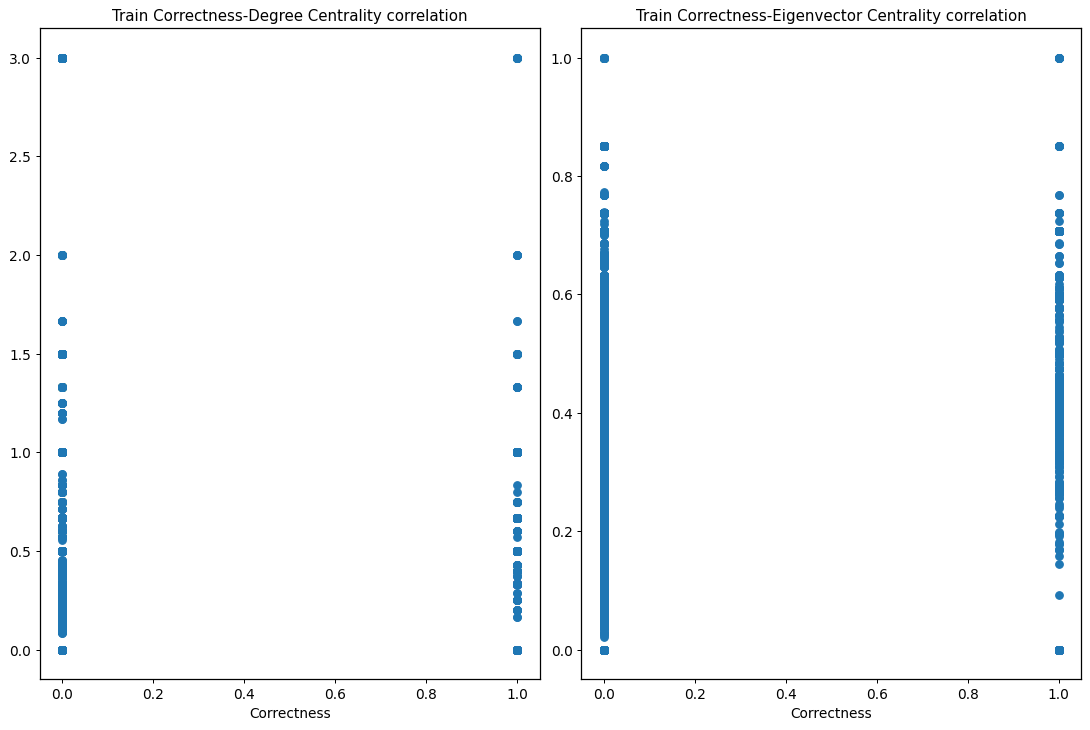

In [44]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8), constrained_layout = True)

ax[0].scatter(result_train_df["correct"], result_train_df["Degree Centrality"])
ax[0].set_xlabel('Correctness')
ax[0].set_title('Train Correctness-Degree Centrality correlation')

ax[1].scatter(result_train_df["correct"], result_train_df["Eigenvector Centrality"])
ax[1].set_xlabel('Correctness')
ax[1].set_title('Train Correctness-Eigenvector Centrality correlation')

#plt.tight_layout()
plt.show()

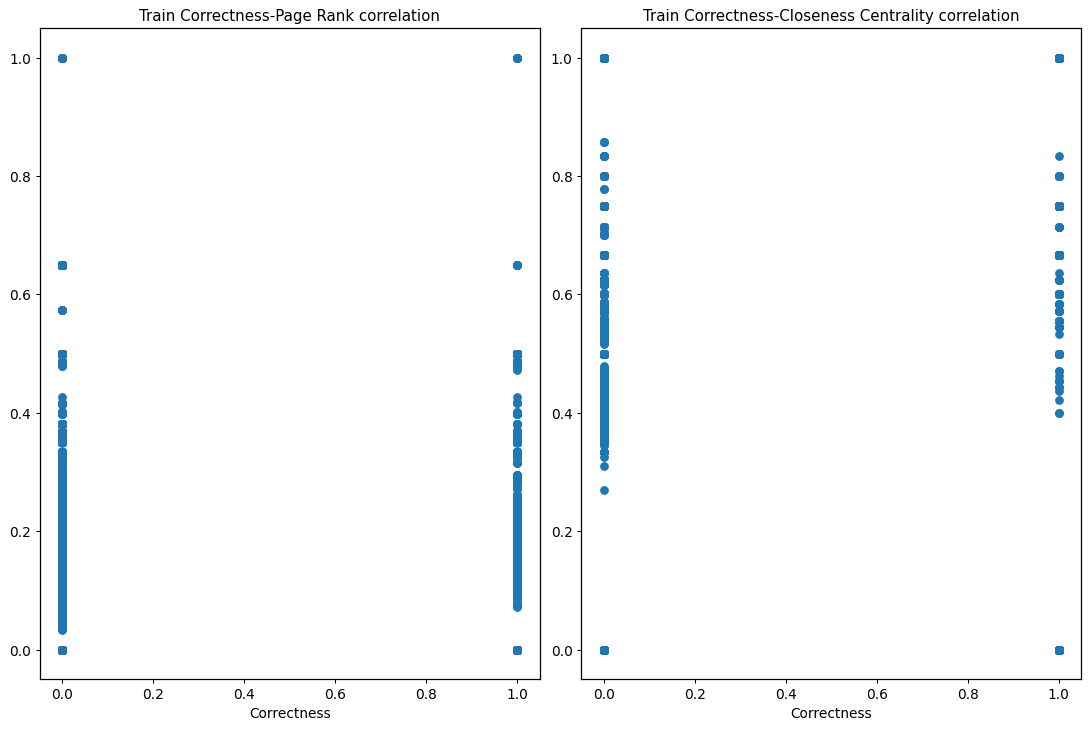

In [45]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8), constrained_layout = True)

ax[0].scatter(result_train_df["correct"], result_train_df["Page Rank"])
ax[0].set_xlabel('Correctness')
ax[0].set_title('Train Correctness-Page Rank correlation')

ax[1].scatter(result_train_df["correct"], result_train_df["Closeness Centrality"])
ax[1].set_xlabel('Correctness')
ax[1].set_title('Train Correctness-Closeness Centrality correlation')

# plt.tight_layout()
plt.show()

In [98]:
max_length = 128
train_dataset = QuestionAnswerDataset(result_train_df, tokenizer=tokenizer, max_length=max_length, context_key="linearized_graph",
                                      tokenizer_truncation="only_second")
dev_dataset = QuestionAnswerDataset(result_val_df, tokenizer=tokenizer, max_length=max_length, context_key="linearized_graph",
                                    tokenizer_truncation="only_second")
test_dataset = QuestionAnswerDataset(result_test_df, tokenizer=tokenizer, max_length=max_length, context_key="linearized_graph",
                                     tokenizer_truncation="only_second")

In [99]:
batch_size = 64
num_workers = 0

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True, drop_last=True,
)
dev_loader = torch.utils.data.DataLoader(
    dev_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False, drop_last=False,
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False, drop_last=False,
)

In [61]:
N_EPOCHS = 30
DROPOUT = 0.2

In [62]:
bert_linearized_graph_clf = BertSimpleClassifier(bert_model, dropout=DROPOUT).to(device)
optimizer = optim.AdamW(bert_linearized_graph_clf.parameters(), lr=2e-5)
criterion = nn.BCEWithLogitsLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='min',
                                           factor=0.95, patience=3,
                                           threshold=1e-3, min_lr=1e-5, verbose=True)

In [63]:
inputs = next(iter(train_loader))
inputs

{'input_ids': tensor([[  101,  2040,  2001,  ...,  2061, 12458,   102],
         [  101,  2029,  6804,  ...,     0,     0,     0],
         [  101,  2073,  2003,  ...,     0,     0,     0],
         ...,
         [  101,  2040,  2003,  ...,     0,     0,     0],
         [  101,  2054,  5195,  ...,  2622,  1010,   102],
         [  101,  2029,  8942,  ...,     0,     0,     0]]),
 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 0, 0, 0]]),
 'labels': tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'graph_length': tensor([ 6,  3,  3,  3,  3,  4,  9, 11,  4,  3,  4, 

In [64]:
train_df.head(1)

,sample_id,question,questionEntity,answerEntity,groundTruthAnswerEntity,answerEntityId,questionEntityId,groundTruthAnswerEntityId,correct,graph,label,linearized_graph,length,density
0,0,Whst is the name of the head of state and highest ranking political and religious authority in Iran?,Iran,Ruhollah Khomeini's return to Iran,Office of the Supreme Leader of Iran,Q7293530,Q794,Q16045000,False,"{'nodes': [{'type': 'QUESTIONS_ENTITY', 'name_': 'Q794', 'id': 0, 'label': 'Iran'}, {'type': 'INTERNAL', 'name_': 'Q207991', 'id': 1, 'label': 'Pahlavi dynasty'}, {'type': 'ANSWER_CANDIDATE_ENTITY', 'name_': 'Q7293530', 'id': 2, 'label': 'Ruhollah Khomeini's return to Iran'}], 'links': [{'name_': 'P17', 'source': 0, 'target': 0, 'label': 'country'}, {'name_': 'P1365', 'source': 0, 'target': 1, 'label': 'replaces'}, {'name_': 'P1366', 'source': 1, 'target': 0, 'label': 'replaced by'}, {'name_': 'P17', 'source': 2, 'target': 1, 'label': 'country'}]}",0.0,"Iran, country, Iran Iran, replaces, Pahlavi dynasty Pahlavi dynasty, replaced by, Iran [SEP] Ruhollah Khomeini's return to Iran [SEP], country, Pahlavi dynasty",3,0.666667


# Training

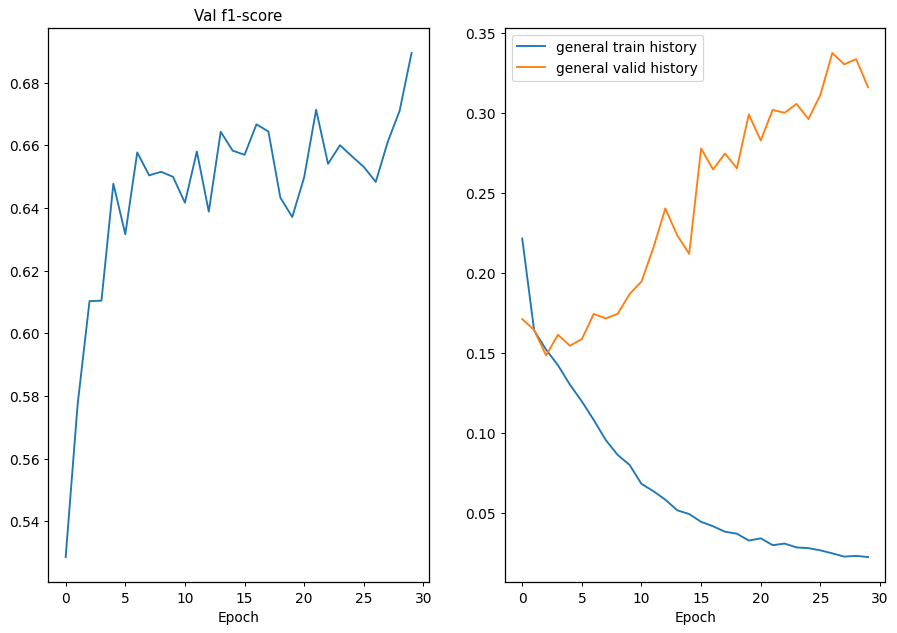

Epoch: 30 | Time: 0m 52s
	Train Loss: 0.023
	 Val. Loss: 0.316 |  Val. F1: 0.689


In [65]:
train_evaluate(bert_linearized_graph_clf, train_loader, dev_loader, optimizer, scheduler,
               criterion, N_EPOCHS, "bert_linearized_graph_clf", device)

In [100]:
true_labels, predicted_labels = predict(model=bert_linearized_graph_clf, data_loader=test_loader, device=device)

In [101]:
f1_score(true_labels, predicted_labels)

0.6300751879699249

# Submition Prediction

In [82]:
class TestQuestionAnswerDataset(Dataset):
    
    def __init__(self, df, tokenizer, max_length, context_key="answerEntity",
                 tokenizer_truncation="only_first", graph_length="length", graph_density="density",
                 degree_centrality="Degree Centrality", eigenvector_centrality="Eigenvector Centrality",
                closeness_centrality="Closeness Centrality", page_rank="Page Rank"):
        
        super(QuestionAnswerDataset).__init__()

        self.questions = df.question.values
        self.contexts = df[context_key].values
        
        self.graph_length = df[graph_length].values
        self.graph_density = df[graph_density].values
        
        self.degree_centrality = df[degree_centrality].values
        self.eigenvector_centrality = df[eigenvector_centrality].values
        self.closeness_centrality = df[closeness_centrality].values
        self.page_rank = df[page_rank].values
        
        # self.labels = torch.tensor(df.label.values, dtype=torch.float32)
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.tokenized_input = [tokenizer.encode_plus(x, y,
                              max_length=self.max_length,
                              padding="max_length",
                              truncation=tokenizer_truncation,
                              return_tensors="pt", ) \
                          for x, y in zip(self.questions,
                                          self.contexts)]
        

    def __len__(self):
        return len(self.questions)

    def __getitem__(self, idx):
        return {
                "input_ids": self.tokenized_input[idx]["input_ids"][0],
                "attention_mask" : self.tokenized_input[idx]["attention_mask"][0],
                # "labels": self.labels[idx],
                "graph_length": self.graph_length[idx],
                "graph_density": self.graph_density[idx],
                "degree_centrality": self.degree_centrality[idx],
                "eigenvector_centrality": self.eigenvector_centrality[idx],
                "closeness_centrality": self.closeness_centrality[idx],
                "page_rank": self.page_rank[idx],
                }

In [90]:
def predict(model, data_loader, device):
    pred_labels = []

    model.eval()
    with torch.no_grad():
        for i, batch in enumerate(data_loader):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            
            graph_length = batch["graph_length"].to(device)
            graph_density = batch["graph_density"].to(device)
            
            degree_centrality = batch["degree_centrality"].to(device) 
            eigenvector_centrality = batch["eigenvector_centrality"].to(device) 
            closeness_centrality = batch["closeness_centrality"].to(device) 
            page_rank = batch["page_rank"].to(device)
            
            pred_probas = model(inputs=input_ids, attention_mask=attention_mask, graph_length=graph_length, graph_density=graph_density, 
                                degree_centrality=degree_centrality, eigenvector_centrality=eigenvector_centrality, 
                                closeness_centrality=closeness_centrality, page_rank=page_rank).squeeze(1)
            pred_probas = pred_probas.cpu().numpy()

            batch_pred_labels = (pred_probas >= 0.5) * 1

            pred_labels.extend(batch_pred_labels)
            
    return pred_labels

In [68]:
test_data = pd.read_csv("/kaggle/input/test-data/test.tsv", sep="\t")
test_data.shape

(10961, 7)

In [71]:
test_data.head(2)

,sample_id,question,questionEntity,answerEntity,questionEntityId,answerEntityId,graph
0,0,"After publishing A Time to Kill, which book did its author begin working on immediately?",A Time to Kill,A Clash of Kings,Q1213715,Q300370,"{'nodes': [{'type': 'INTERNAL', 'name_': 'Q30', 'id': 0, 'label': 'United States'}, {'type': 'ANSWER_CANDIDATE_ENTITY', 'name_': 'Q300370', 'id': 1, 'label': 'A Clash of Kings'}, {'type': 'QUESTIONS_ENTITY', 'name_': 'Q1213715', 'id': 2, 'label': 'A Time to Kill'}], 'links': [{'name_': 'P17', 'source': 0, 'target': 0, 'label': 'country'}, {'name_': 'P495', 'source': 1, 'target': 0, 'label': 'country of origin'}, {'name_': 'P495', 'source': 2, 'target': 0, 'label': 'country of origin'}]}"
1,1,"After publishing A Time to Kill, which book did its author begin working on immediately?",A Time to Kill,A Feast for Crows,Q1213715,Q1764445,"{'nodes': [{'type': 'INTERNAL', 'name_': 'Q30', 'id': 0, 'label': 'United States'}, {'type': 'ANSWER_CANDIDATE_ENTITY', 'name_': 'Q1764445', 'id': 1, 'label': 'A Feast for Crows'}, {'type': 'QUESTIONS_ENTITY', 'name_': 'Q1213715', 'id': 2, 'label': 'A Time to Kill'}], 'links': [{'name_': 'P17', 'source': 0, 'target': 0, 'label': 'country'}, {'name_': 'P495', 'source': 1, 'target': 0, 'label': 'country of origin'}, {'name_': 'P495', 'source': 2, 'target': 0, 'label': 'country of origin'}]}"


In [72]:
test_data["graph"] = test_data["graph"].apply(eval)
test_data["linearized_graph"], test_data["length"], test_data["density"] = zip(*test_data.apply(linearize_graph, axis=1))
test_data.head(2)

,sample_id,question,questionEntity,answerEntity,questionEntityId,answerEntityId,graph,linearized_graph,length,density
0,0,"After publishing A Time to Kill, which book did its author begin working on immediately?",A Time to Kill,A Clash of Kings,Q1213715,Q300370,"{'nodes': [{'type': 'INTERNAL', 'name_': 'Q30', 'id': 0, 'label': 'United States'}, {'type': 'ANSWER_CANDIDATE_ENTITY', 'name_': 'Q300370', 'id': 1, 'label': 'A Clash of Kings'}, {'type': 'QUESTIONS_ENTITY', 'name_': 'Q1213715', 'id': 2, 'label': 'A Time to Kill'}], 'links': [{'name_': 'P17', 'source': 0, 'target': 0, 'label': 'country'}, {'name_': 'P495', 'source': 1, 'target': 0, 'label': 'country of origin'}, {'name_': 'P495', 'source': 2, 'target': 0, 'label': 'country of origin'}]}","United States, country, United States [SEP] A Clash of Kings [SEP], country of origin, United States A Time to Kill, country of origin, United States",3,0.5
1,1,"After publishing A Time to Kill, which book did its author begin working on immediately?",A Time to Kill,A Feast for Crows,Q1213715,Q1764445,"{'nodes': [{'type': 'INTERNAL', 'name_': 'Q30', 'id': 0, 'label': 'United States'}, {'type': 'ANSWER_CANDIDATE_ENTITY', 'name_': 'Q1764445', 'id': 1, 'label': 'A Feast for Crows'}, {'type': 'QUESTIONS_ENTITY', 'name_': 'Q1213715', 'id': 2, 'label': 'A Time to Kill'}], 'links': [{'name_': 'P17', 'source': 0, 'target': 0, 'label': 'country'}, {'name_': 'P495', 'source': 1, 'target': 0, 'label': 'country of origin'}, {'name_': 'P495', 'source': 2, 'target': 0, 'label': 'country of origin'}]}","United States, country, United States [SEP] A Feast for Crows [SEP], country of origin, United States A Time to Kill, country of origin, United States",3,0.5


In [79]:
final_test_metrics = getting_features(test_data, mode="test")
final_test_metrics = final_test_metrics.fillna(0.0)

temp_test_df = test_data.copy()
temp_test_df = temp_test_df.reset_index(drop=True)
final_test_metrics = final_test_metrics.reset_index(drop=True)

result_test_df = temp_test_df.join(final_test_metrics, how="inner")

100%|██████████| 10961/10961 [00:52<00:00, 208.13it/s]


In [83]:
max_length = 128

final_test_data = TestQuestionAnswerDataset(result_test_df, tokenizer=tokenizer, max_length=max_length, context_key="linearized_graph",
                                     tokenizer_truncation="only_second")

In [84]:
batch_size = 128
num_workers = 0

test_loader = torch.utils.data.DataLoader(
    final_test_data, batch_size=batch_size, num_workers=num_workers, shuffle=False, drop_last=False,
)

In [91]:
predicted_labels = predict(model=bert_linearized_graph_clf, data_loader=test_loader, device=device)

In [92]:
results = pd.concat([pd.Series(np.arange(len(predicted_labels))), pd.Series(predicted_labels)], axis=1)
results.rename(columns={0: "sample_id", 1: "prediction"}, inplace=True)
results.head(5)

,sample_id,prediction
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [93]:
results.to_csv("results.csv", index=False, sep="\t")